# Prerequisites

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta
import torch.optim as optim

is_on_colab = False

In [2]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone'
Hypers.Config.data_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\data'
Hypers.Config.model_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\model'
Hypers.Config.log_path='d:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\log'


In [3]:
suffix = "US_newlabel"

In [4]:
# Optional: Split data into train and test
# You have to run this cell if you changed your feature,rating dataset
path = 'data/final_US_new.pkl'
# merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "data_US.pkl"))
merged_dict = utils.load_pickle(path)
train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=False, suffix=suffix)
print(len(train_dict), len(test_dict))

690 85


In [5]:
def remove_companies_with_few_quarters(train_dict, min_quarters=3):
    filtered_dict = {}

    for company, periods in train_dict.items():
        if len(periods) >= min_quarters:
            filtered_dict[company] = periods
    
    return filtered_dict

from collections import defaultdict

def count_labels_in_train_dict(train_dict):
    label_count = defaultdict(int)
    
    for company, periods in train_dict.items():
        for period, (features, label, normalized_label) in periods.items():
            label_value = label.item()  # 获取标签值
            label_count[label_value] += 1
    
    return label_count

In [6]:
train_dict = remove_companies_with_few_quarters(train_dict, min_quarters=3)
print(len(train_dict), len(test_dict))

666 85


In [7]:
label_counts = {3: 0, 4: 0, 5: 0}

# 统计当前数据集中每个标签的数量
for company_id, quarters in train_dict.items():
    for quarter, content in quarters.items():
        label = content[1].item()  # 提取标签的值（tensor中的值）
        if label in label_counts:
            label_counts[label] += 1

In [8]:
label_counts

{3: 5112, 4: 4706, 5: 2647}

In [9]:
target_count = 2500

# 定义一个新的字典来存放处理后的数据
filtered_train_dict = {}

# 第一次删除：删除那些所有季度都属于目标标签的公司
for label in [3, 4, 5]:
    companies_to_delete = []
    if label_counts[label] > target_count:
        for company_id in list(train_dict.keys()):
            if label_counts[label] <= target_count:
                break  # 如果标签数量已经达到目标，停止删除

            # 检查该公司的所有季度是否全都是该标签
            company_labels = [content[1].item() for content in train_dict[company_id].values()]
            if all(l == label for l in company_labels):
                # 如果该公司的所有季度数据都具有同一个标签，删除该公司
                label_counts[label] -= len(company_labels)
                companies_to_delete.append(company_id)

        # 执行删除操作
        for company_id in companies_to_delete:
            del train_dict[company_id]

# 第二轮删除：删除那些包含目标标签的公司，直到数量符合要求
for label in [3, 4, 5]:
    companies_to_delete = []
    if label_counts[label] > target_count:
        for company_id in list(train_dict.keys()):
            if label_counts[label] <= target_count:
                break  # 如果标签数量已经达到目标，停止删除

            # 检查公司是否有任何一个标签为当前目标标签
            company_labels = [content[1].item() for content in train_dict[company_id].values()]
            if any(l == label for l in company_labels):
                # 记录该公司中有多少个该标签
                label_occurrences = company_labels.count(label)
                # 标记删除公司
                label_counts[label] -= label_occurrences
                companies_to_delete.append(company_id)

        # 执行删除操作
        for company_id in companies_to_delete:
            del train_dict[company_id]

# 重新统计每个标签的数量
final_label_counts = {3: 0, 4: 0, 5: 0}
for company_id, quarters in train_dict.items():
    for quarter, content in quarters.items():
        label = content[1].item()
        if label in final_label_counts:
            final_label_counts[label] += 1

# 输出最终结果
print(f"最终每个标签的数量: {final_label_counts}")

最终每个标签的数量: {3: 2475, 4: 2482, 5: 2483}


In [10]:
label_counts = count_labels_in_train_dict(train_dict)

# 打印每个标签的数量
print("标签数量统计:")
for label, count in label_counts.items():
    print(f"标签 {label} 的数量: {count}")

标签数量统计:
标签 5.0 的数量: 2483
标签 10.0 的数量: 72
标签 4.0 的数量: 2482
标签 3.0 的数量: 2475
标签 2.0 的数量: 2295
标签 1.0 的数量: 487
标签 0.0 的数量: 96
标签 6.0 的数量: 143
标签 7.0 的数量: 10
标签 9.0 的数量: 1


In [11]:
label_counts = count_labels_in_train_dict(test_dict)

# 打印每个标签的数量
print("标签数量统计:")
for label, count in label_counts.items():
    print(f"标签 {label} 的数量: {count}")

标签数量统计:
标签 3.0 的数量: 491
标签 1.0 的数量: 93
标签 5.0 的数量: 312
标签 2.0 的数量: 275
标签 4.0 的数量: 500
标签 6.0 的数量: 11
标签 9.0 的数量: 31
标签 10.0 的数量: 5
标签 0.0 的数量: 27


# LSTM

In [12]:
import LSTMDataset
importlib.reload(LSTMDataset)
import LSTMModel
importlib.reload(LSTMModel)

model_type = "Lstm"

In [13]:
# train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "train_dict_RetInd_4.pkl"))
# test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "test_dict_RetInd_4.pkl"))
# print(f"{len(train_dict)}", f"{len(test_dict)}")

# max_seq_len = max(max([len(entries) for entries in train_dict.values()]), max([len(entries) for entries in test_dict.values()]))
max_seq_len = 2
print(f"{max_seq_len=}")

model = LSTMModel.LSTMModel(input_size=38,
                                      hidden_size=Hypers.Config.hidden_size,
                                      num_layers=max_seq_len,
                                      proj_size=Hypers.Config.proj_size)
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_seq_len=2


In [16]:
model

LSTMModel(
  (lstm): LSTM(38, 4, num_layers=2, batch_first=True)
  (batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)

Vaild Epoch 299: 100%|██████████| 300/300 [04:47<00:00,  1.04it/s, Loss: 0.000]


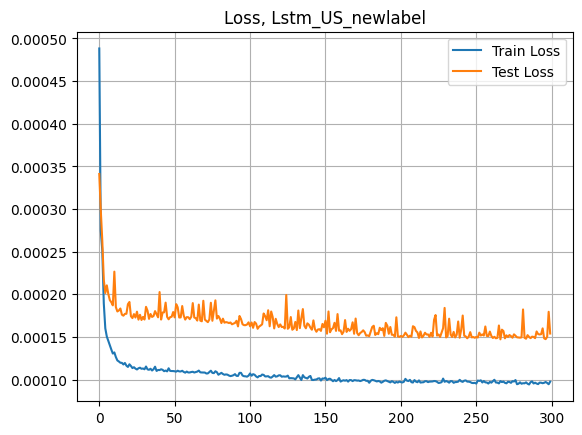

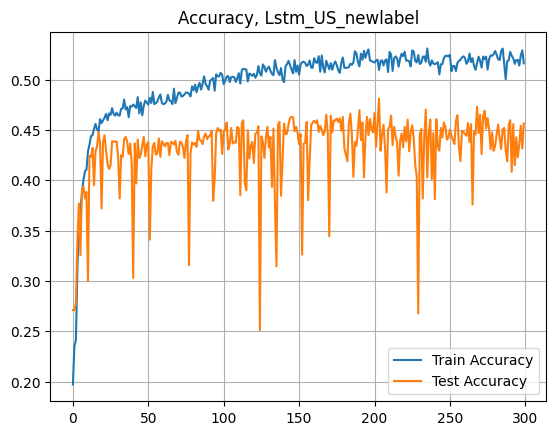

In [15]:
train_set, test_set = LSTMDataset.LSTMDataset(train_dict), LSTMDataset.LSTMDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)

trainer = Trainer.Trainer(model, criterion, optimizer, device, train_loader, test_loader, max_seq_len)
train_loss, train_accuracy, test_loss, test_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, test_loss, test_accuracy, identifier=f"{model_type}_{suffix}")

In [16]:
for batch in train_loader:
    print(batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape)
    break


torch.Size([16, 4, 38]) torch.Size([16, 4]) torch.Size([16, 4]) torch.Size([16, 4])


# Regression

In [6]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

model_type = "Regr"

In [7]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")

len(train_dict)=595 len(test_dict)=171


In [8]:
input_size = len(train_dict["AMZN"]["2010Q4"][0])
print(f"{input_size=}")

input_size=192


Vaild Epoch 499: 100%|██████████| 500/500 [15:59<00:00,  1.92s/it, Loss: 6.762]  


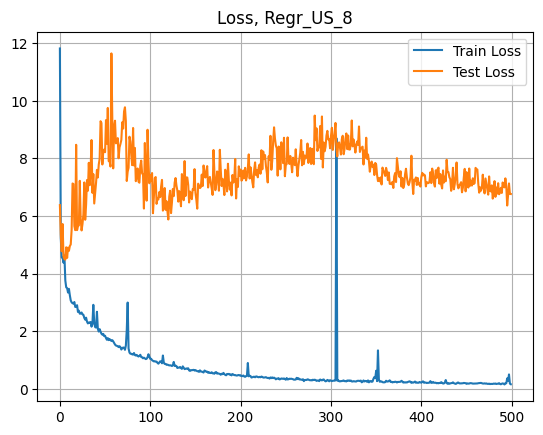

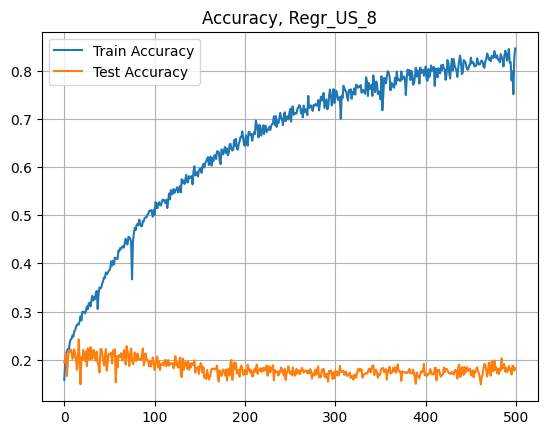

In [9]:
train_set = RegressionDataset.RegressionDataset(train_dict)
valid_set = RegressionDataset.RegressionDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)

model = RegressionModel.RegressionModel(input_size=input_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader, 
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Conv1d

In [10]:
import ConvDataset
importlib.reload(ConvDataset)
import ConvModel
importlib.reload(ConvModel)

model_type = "Conv"

In [11]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")
print(suffix)

len(train_dict)=595 len(test_dict)=171
US_8


Vaild Epoch 499: 100%|██████████| 500/500 [16:46<00:00,  2.01s/it, Loss: 13.230] 


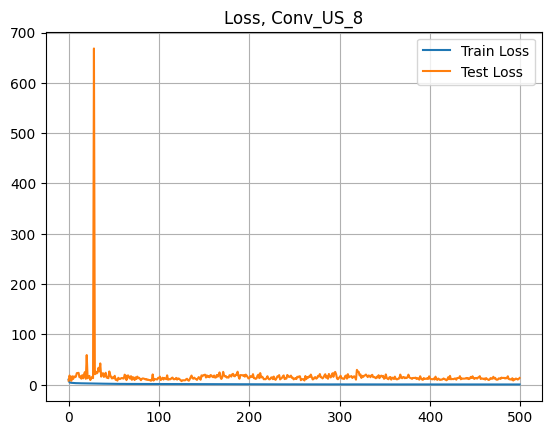

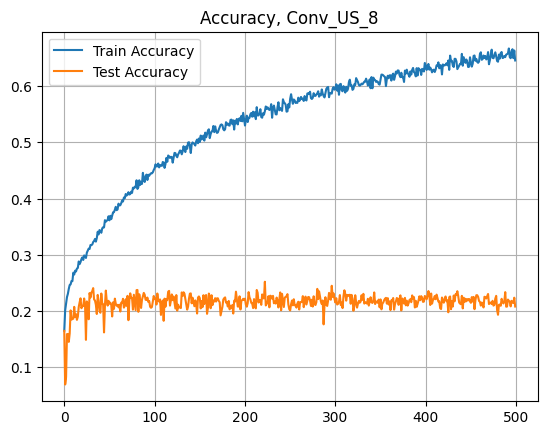

In [12]:
train_set = ConvDataset.ConvDataset(train_dict, window_size=8)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=8)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)

model = ConvModel.ConvModel(feature_size=24)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader, 
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Infer

In [16]:
import Inferencer
importlib.reload(Inferencer)

<module 'Inferencer' from 'd:\\Document\\Ucla-doc\\263\\project\\PNC_Capstone\\Inferencer.py'>

In [17]:
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=False, collate_fn=LSTMDataset.LSTMDataset.custom_collate_fn)
inferencer = Inferencer.Inferencer(model=model, test_loader=test_loader, device=device)
predictions, turths, features, accuracy, diff_counter = inferencer.infer()

In [18]:
type(predictions)

torch.Tensor

In [19]:
len(turths)

1812

In [20]:
nums = 10
print(predictions[:nums])
print(turths[:nums])

tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.], device='cuda:0')
tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.], device='cuda:0')


In [21]:
print(diff_counter)

Counter({0.0: 795, 1.0: 742, 2.0: 215, 5.0: 27, 3.0: 24, 4.0: 8, 6.0: 1})


In [22]:
total_count = sum(diff_counter.values())
print(f"{total_count=}")

total_count=1812


In [23]:
accumulated_count = []

for i in range(0, 33):
    count = diff_counter[i]
    if i==0:
        accumulated_count.append(count)
        continue
    accumulated_count.append(accumulated_count[-1]+count)

accumulated_accuracy = [i/total_count for i in accumulated_count]
accumulated_accuracy[:5]

[0.43874172185430466,
 0.8482339955849889,
 0.9668874172185431,
 0.9801324503311258,
 0.9845474613686535]

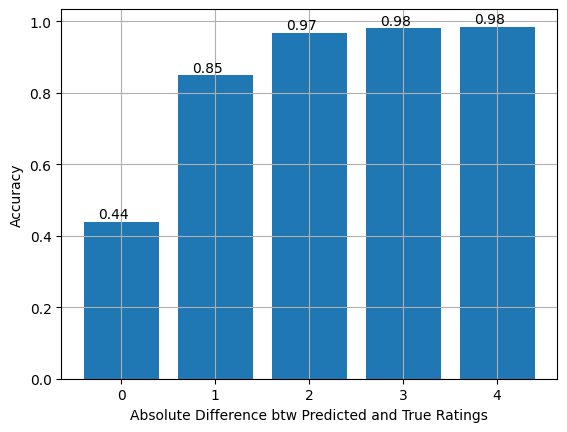

In [24]:
import matplotlib.pyplot as plt

plt.bar(range(0,5), accumulated_accuracy[:5])
for i, v in enumerate(accumulated_accuracy[:5]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.xlabel("Absolute Difference btw Predicted and True Ratings")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [26]:
def count_labels(labels, label_name=""):
    unique_labels, counts = torch.unique(labels, return_counts=True)
    print(f"\n{label_name} 中的标签及其数量:")
    for label, count in zip(unique_labels, counts):
        print(f"标签 {label.item()} 的数量: {count.item()}")

In [27]:
count_labels(turths, label_name="Truths")
count_labels(predictions, label_name="Predictions")


Truths 中的标签及其数量:
标签 0.0 的数量: 94
标签 1.0 的数量: 93
标签 2.0 的数量: 275
标签 3.0 的数量: 491
标签 4.0 的数量: 500
标签 5.0 的数量: 312
标签 6.0 的数量: 11
标签 9.0 的数量: 31
标签 10.0 的数量: 5

Predictions 中的标签及其数量:
标签 -0.0 的数量: 67
标签 2.0 的数量: 283
标签 3.0 的数量: 456
标签 4.0 的数量: 861
标签 5.0 的数量: 145


In [27]:
count_labels(turths, label_name="Truths")
count_labels(predictions, label_name="Predictions")


Truths 中的标签及其数量:
标签 0.0 的数量: 94
标签 1.0 的数量: 93
标签 2.0 的数量: 275
标签 3.0 的数量: 491
标签 4.0 的数量: 500
标签 5.0 的数量: 312
标签 6.0 的数量: 11
标签 9.0 的数量: 31
标签 10.0 的数量: 5

Predictions 中的标签及其数量:
标签 -0.0 的数量: 67
标签 1.0 的数量: 89
标签 2.0 的数量: 238
标签 3.0 的数量: 442
标签 4.0 的数量: 601
标签 5.0 的数量: 365
标签 6.0 的数量: 10


In [28]:
def count_entries_in_nested_dict(nested_dict):
    count = 0
    for company, periods in nested_dict.items():
        count += len(periods)
    return count

In [29]:
total_entries = count_entries_in_nested_dict(train_dict)
print(f"总共有 {total_entries} 条数据")

总共有 10544 条数据


In [30]:
total_entries = count_entries_in_nested_dict(test_dict)
print(f"总共有 {total_entries} 条数据")

总共有 1745 条数据
